In [92]:
import networkx as nx
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from fa2 import ForceAtlas2
from community import community_louvain
import matplotlib.cm as cm
from collections import Counter



In [2]:
charactersDf = pd.read_csv('characters.csv')
charactersDf.head()

,Unnamed: 0,Name
0,0,Aragorn II Elessar
1,1,Arwen
2,2,Frodo Baggins
3,3,Balin
4,4,Bilbo Baggins


In [3]:
pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
# pattern2 = '\{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|link)?\}\}'
gender = '(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)'
race = '(?:race=\s)\{\{Term\|BotW\|(.*?)\|link\}\}'
culture = '(?:Culture=\s)([a-zA-Z]*)(?:<.*?\/>)'


In [31]:
with open("txtfiles/" + charactersDf.Name[0] + '.txt',encoding='utf-8') as f:
    text = f.read()
print(text)

<br />{{Featured star}}
{{Disamb-two|son of Arathorn II|son of Aravir|[[Aragorn I]]}}
{{Disamb-more|Ranger of the North|[[Strider (disambiguation)]]}}
{{Infobox Person Men Dúnedain
| image = Aragorn profile.jpg
| caption = [[Viggo Mortensen]] portrays Aragorn in [[The Lord of the Rings film trilogy]]
| name = 
| othernames = Estel, Thorongil, Elessar (Edhelharn), Telcontar, Envinyatar, Strider, the Dúnadan, Wingfoot
| title = [[Chieftain of the Dúnedain]], [[Heir of Isildur|Heir]] of [[Isildur]]<br />[[King of all the Dúnedain|High]] [[King of the Reunited Kingdom|King]] of the [[Dúnedain]], [[Kings of Arnor|King]] of [[Arnor]], [[Kings of Gondor|King]] of [[Gondor]]
| birth = [[March 1]], [[TA 2931]]
| rule = [[TA 2933]] to [[TA 3019|3019]] (86 years as a Chieftain)<br />[[TA 3019]] to [[FO 120]] (122 years as a King)
| death = [[FO 120]] (aged 210)
| realms = [[Reunited Kingdom]] ([[Arnor]] and [[Gondor]])
| parentage = 
| spouse = [[Arwen|Arwen Undómiel]]
| children = [[Eldarion]] &

In [181]:
def nodeInfo(text):
    genderRe1 = re.findall(r'(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)',text)
    if genderRe1:
        if genderRe1[0] == '':
            gender = 'Unknown'
        else:
            gender = genderRe1[0]
    else:
        gender = 'Unknown'
    raceRe2 = re.findall(r'(?i)(?:race\s*=\s*)\[\[(.*?)(?:\|.*?)?\]\]',text)

    if raceRe2:
        race = raceRe2[0] 
    else:
        race = 'none'

    cultureRe1 = re.findall(r'(?i)(?:culture\s*=[^\S\n]*)(.*)(?:\||\n)',text)
    if cultureRe1:
        cultureRe2 = re.findall(r'\[\[(.*?)(?:\|.*?)?\]\]',cultureRe1[0])
        culture = cultureRe2
    else:
        culture = ['Unkown']

    pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
    square = re.findall(pattern1,text)
    edges = square
    

    return gender,race,culture,edges

g,r,c,e = nodeInfo(text)
print(c)


['Mordor']


In [182]:
def filterC(chars,charList):
    ret = []
    i = 0
    # print(charList)
    for i in range(len(chars)):
        # print(name, name in charList,type(name))
        if chars[i] in charList:
            ret.append(chars[i])
    return ret
charList = filterC(e,list(charactersDf.Name))
# print(e[11] in list(charactersDf.Name),e[13])
print(len(charList),charList)

2 ['Shagrat', 'Shelob']


In [183]:
def tuples(name, list):
    tmp = []
    for item in list:
        tmp.append((name,item))
    return tmp

In [184]:
nameList = list(charactersDf.Name)
G = nx.DiGraph()

for row in charactersDf.iterrows():
    # try:
    #     name= row[1]['Name']
    #     with open("txtfiles/" + name + '.txt',encoding='utf-8') as f:
    #         text = f.read()
    #     g,r,e = nodeInfo(text)
    #     charList = tuples(filterC(name,e))
    #     G.add_node(name,race = r, gender = g)
    #     # networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    #     G.add_edges_from(charList)
            
    # except:
    #     print('failed',name)

    name= row[1]['Name']
    with open("txtfiles/" + name + '.txt',encoding='utf-8') as f:
        text = f.read()
    g,r,c,e = nodeInfo(text)
    charList = tuples(name,filterC(e,list(charactersDf.Name)))
    G.add_node(name,race = r, gender = g, cultures = c)
    # networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    G.add_edges_from(charList)
            

    
    


In [185]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 121
Number of edges: 710
Average in degree:   5.8678
Average out degree:   5.8678


In [186]:
#Extracting the giant component
GunD = G.to_undirected()
giant = list(max(nx.connected_components(GunD), key=len))
gcc = G.subgraph(giant).copy()

In [187]:
print(nx.info(gcc))

Name: 
Type: DiGraph
Number of nodes: 115
Number of edges: 710
Average in degree:   6.1739
Average out degree:   6.1739


Text(0.5, 1.0, 'Distribution of total degrees')

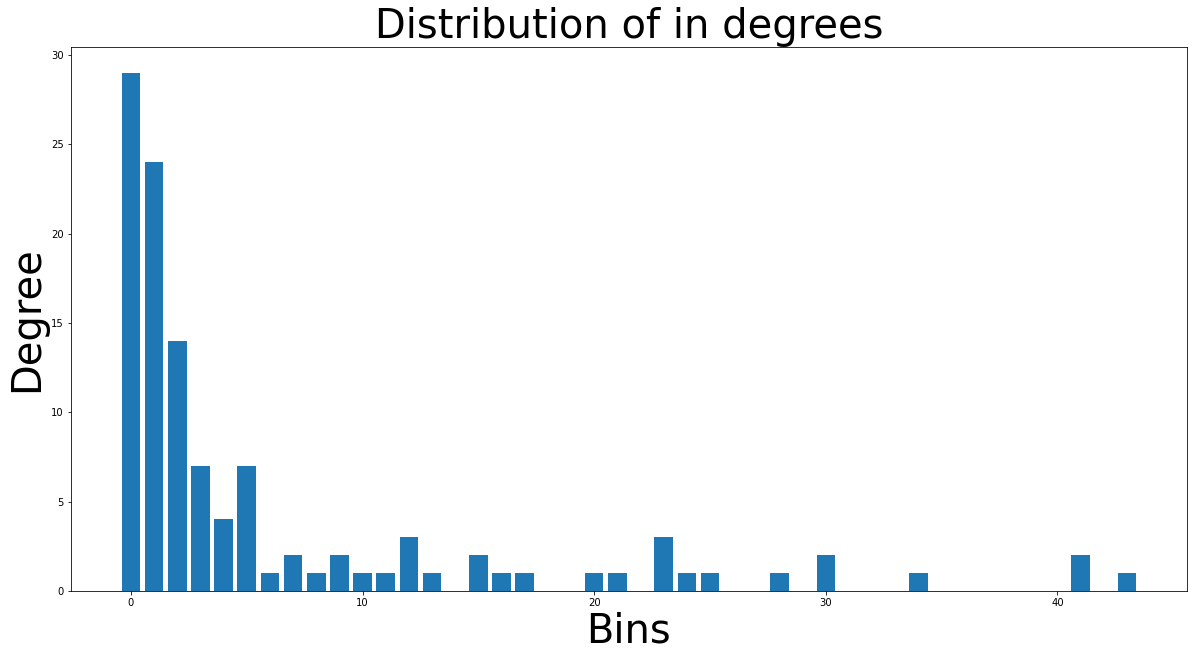

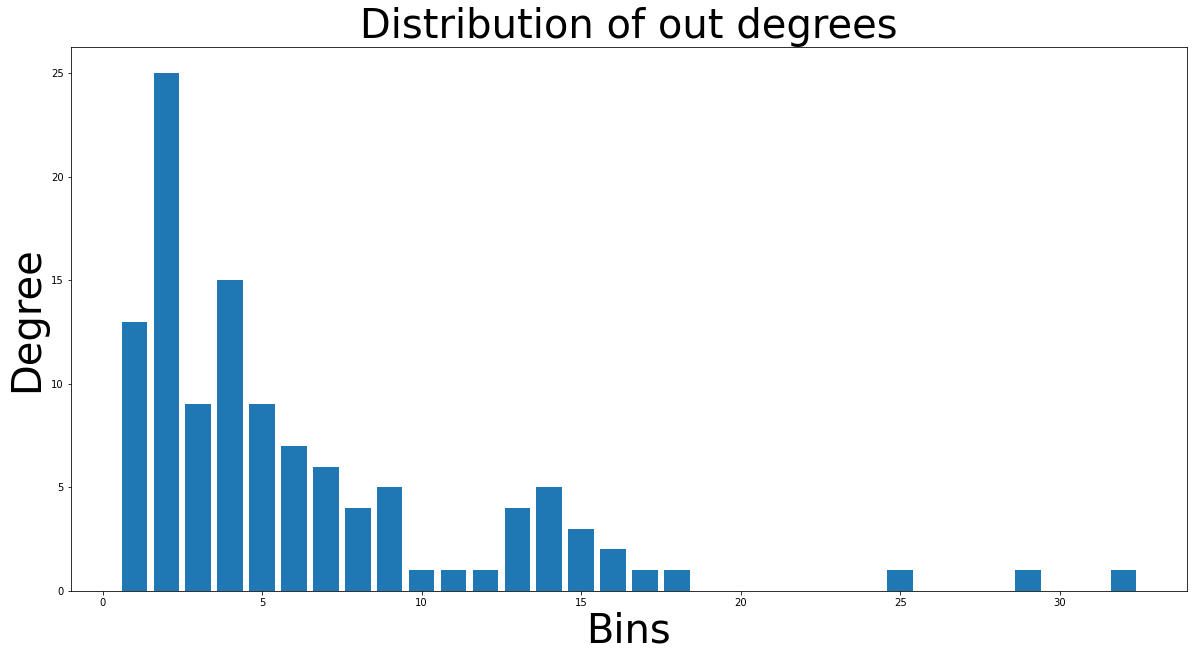

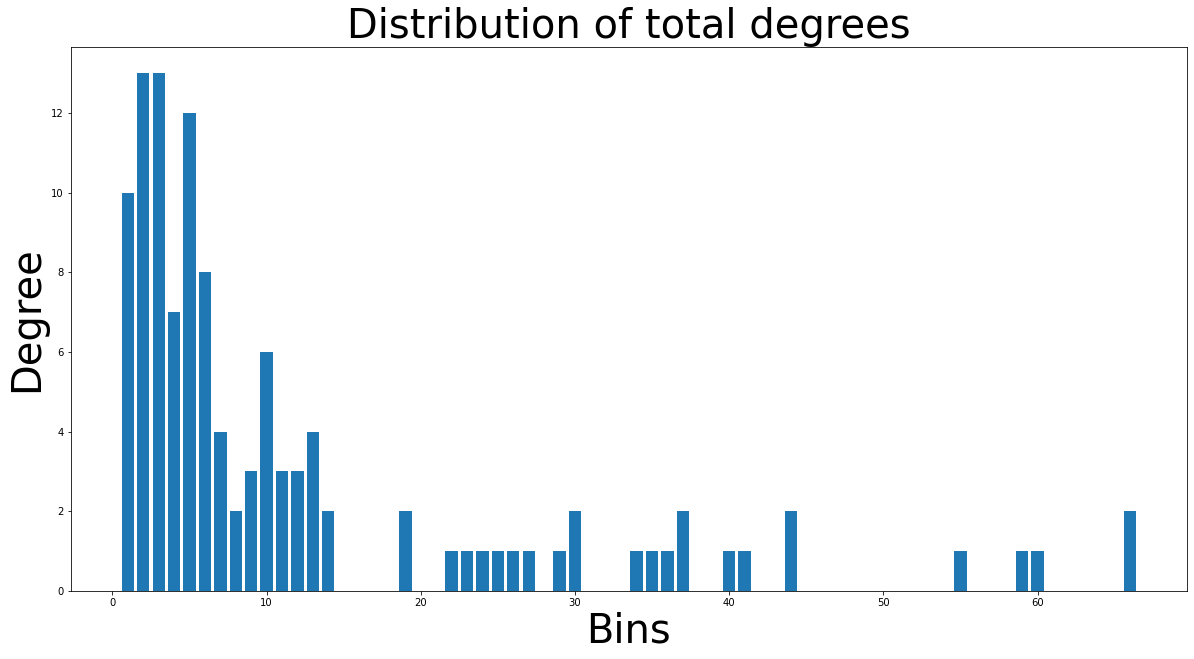

In [188]:
inDegree = [gcc.in_degree(node) for node in gcc.nodes()]
outDegree = [gcc.out_degree(node) for node in gcc.nodes()]
totalDegree = [gcc.degree(node) for node in gcc.nodes()]

maxIn = max(inDegree,key=lambda item:item)
maxOut = max(outDegree,key=lambda item:item)
maxTotal = max(totalDegree,key=lambda item:item)

minIn = min(inDegree,key=lambda item:item)
minOut = min(outDegree,key=lambda item:item)
minTotal = min(totalDegree,key=lambda item:item)
fontSize = 40

vIn = np.linspace(minIn, maxIn, maxIn-minIn+1)
counts, vIn = np.histogram(inDegree, vIn)
plt.figure(figsize=(20,10))
plt.bar(vIn[:-1], counts)
plt.xlabel("Bins", fontsize=fontSize)
plt.ylabel("Degree", fontsize=fontSize)
plt.title('Distribution of in degrees', fontsize=fontSize)

vOut = np.linspace(minOut, maxOut, maxOut-minOut+1)
counts, vOut = np.histogram(outDegree, vOut)
plt.figure(figsize=(20,10))
plt.bar(vOut[:-1], counts)
plt.xlabel("Bins",fontsize=fontSize)
plt.ylabel("Degree",fontsize=fontSize)
plt.title('Distribution of out degrees',fontsize=fontSize)

vTotal = np.linspace(minTotal, maxTotal, maxTotal-minTotal+1)
counts, vTotal = np.histogram(totalDegree, vTotal)
plt.figure(figsize=(20,10))
plt.bar(vTotal[:-1], counts)
plt.xlabel("Bins",fontsize=fontSize)
plt.ylabel("Degree",fontsize=fontSize)
plt.title('Distribution of total degrees',fontsize=fontSize)



In [189]:
print(gcc.degree)

[('Aragorn II Elessar', 67), ('Isildur', 19), ('Arwen', 23), ('Eldarion', 10), ('Elendil', 12), ('Elrond', 36), ('Galadriel', 41), ('Gandalf', 59), ('Sauron', 55), ('Bilbo Baggins', 25), ('Gollum', 30), ('Barliman Butterbur', 6), ('Frodo Baggins', 66), ('Boromir', 29), ('Peregrin Took', 44), ('Meriadoc Brandybuck', 44), ('Samwise Gamgee', 34), ('Legolas', 37), ('Gimli', 40), ('Saruman', 60), ('Watcher in the Water', 10), ("Durin's Bane", 8), ('Éomer', 37), ('Théoden', 35), ('Gríma Wormtongue', 19), ('Denethor II', 14), ('Faramir', 30), ('Éowyn', 27), ('Witch-king of Angmar', 26), ('Mouth of Sauron', 10), ('Bill Ferny', 7), ('Celeborn', 22), ('Círdan', 12), ('Lurtz', 4), ('Glóin', 10), ('Farmer Maggot', 5), ('Shelob', 14), ('Gwaihir', 13), ('Rosie Cotton', 10), ('Elanor Gardner', 7), ('Balin', 9), ('Bell Boffin', 3), ('Minto Boffin', 3), ('Filibert Bolger', 2), ('Fredegar Bolger', 6), ('Uglúk', 13), ('Melilot Brandybuck', 1), ('Grishnákh', 11), ('Treebeard', 24), ('Calaglin', 2), ('Gil-

In [190]:
d = dict(gcc.degree)

# nx.draw(gcc, nodelist=d.keys(), node_size=[(v+1) * 20 for v in d.values()])
# plt.figure(figsize=(20,10))
# plt.show()
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=100.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1002.39it/s]

BarnesHut Approximation  took  0.28  seconds
Repulsion forces  took  1.52  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


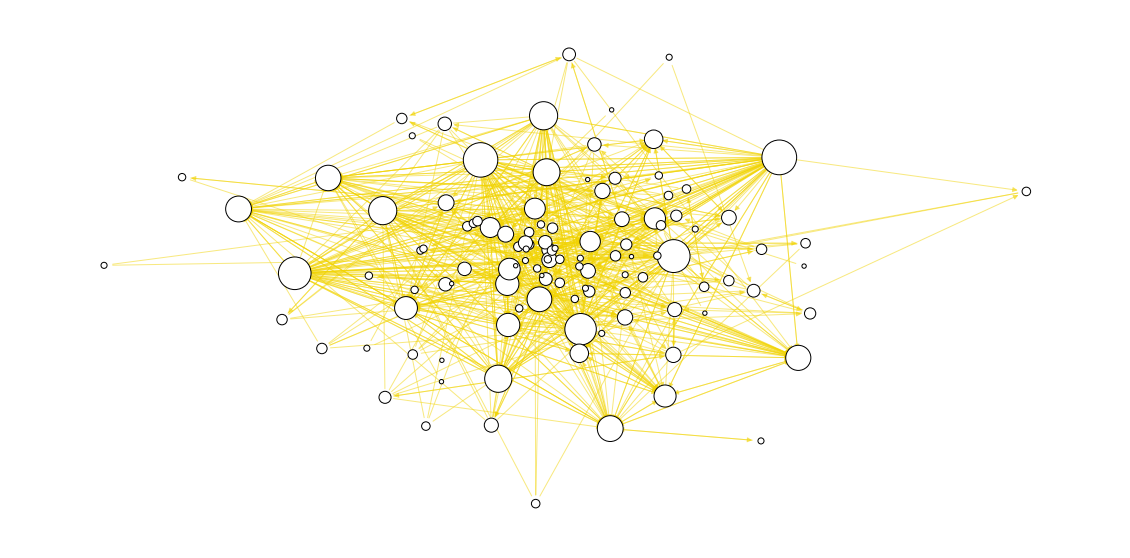

In [191]:
list_degree=list(gcc.degree()) #this will return a list of tuples each tuple is(node,deg)
nodes , degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list


plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(gcc, positions, nodelist=nodes, node_size=[(v * 18)+1 for v in degree], edgecolors="black", node_color= "#ffffff")
nx.draw_networkx_edges(gcc, positions,edge_color = "#F1D302", alpha = 0.5)
plt.axis('off')

plt.show()

In [192]:
cultures1 = [(node[0],node[1]['cultures']) for node in G.nodes(data = True)]
with open('your_file.txt', 'w', encoding='utf-8') as f:
    for item in cultures1:
        f.write(str(item[0]) + ',' + str(item[1]) +  "\n"  )
        # print(type(item))
print(cultures1)

[('Aragorn II Elessar', ['Dúnedain of Arnor', 'House of Isildur', 'House of Telcontar']), ('Isildur', ['Unkown']), ('Arwen', ['Lindon', 'Rivendell']), ('Eldarion', ['Dúnedain', 'House of Telcontar']), ('Elendil', ['The Faithful', 'Númenoreans', 'Lords of Andúnië', 'Andúnië']), ('Elrond', []), ('Galadriel', ['Ñoldor', 'House of Finarfin', 'Falmari', 'House of Olwë']), ('Gandalf', ['Wizards']), ('Sauron', ['Maiar', 'Melkor', 'Aulë']), ('Bilbo Baggins', ['Shire', 'Baggins family']), ('Gollum', ['Stoor']), ('Barliman Butterbur', ['Men of Bree']), ('Frodo Baggins', ['Shire', 'Brandybuck', 'Baggins family']), ('Boromir', ['Men of Gondor', 'House of Húrin']), ('Peregrin Took', ['Shire', 'Tooks']), ('Meriadoc Brandybuck', ['Shire', 'Buckland', 'Brandybucks']), ('Samwise Gamgee', ['Shire', 'Gamgee']), ('Legolas', ['Sindar']), ('Gimli', ["Durin's Folk"]), ('Saruman', ['Maiar', 'Aulë', 'Wizards']), ('Watcher in the Water', []), ("Durin's Bane", ['Valaraukar']), ('Éomer', ['Rohirrim', 'House of Eo

In [193]:
races1 = [(node[0],node[1]['race']) for node in G.nodes(data = True)]
print(races1)

[('Aragorn II Elessar', 'Men'), ('Isildur', 'Men'), ('Arwen', 'Half-elven'), ('Eldarion', 'Men'), ('Elendil', 'Men'), ('Elrond', 'Half-elven'), ('Galadriel', 'Elves'), ('Gandalf', 'Ainur'), ('Sauron', 'Ainur'), ('Bilbo Baggins', 'Hobbits'), ('Gollum', 'Hobbits'), ('Barliman Butterbur', 'Men'), ('Frodo Baggins', 'none'), ('Boromir', 'Men'), ('Peregrin Took', 'Hobbits'), ('Meriadoc Brandybuck', 'Hobbit'), ('Samwise Gamgee', 'Hobbits'), ('Legolas', 'Elves'), ('Gimli', 'Dwarves'), ('Saruman', 'Ainur'), ('Watcher in the Water', 'none'), ("Durin's Bane", 'none'), ('Éomer', 'Men'), ('Théoden', 'Men'), ('Gríma Wormtongue', 'Men'), ('Denethor II', 'Men'), ('Faramir', 'Men'), ('Éowyn', 'Men'), ('Witch-king of Angmar', 'Man'), ('Mouth of Sauron', 'Men'), ('Bill Ferny', 'Men'), ('Celeborn', 'Elves'), ('Círdan', 'Elves'), ('Lurtz', 'Orcs'), ('Glóin', 'Dwarves'), ('Farmer Maggot', 'Hobbits'), ('Shelob', 'Spiders'), ('Gwaihir', 'Great Eagles'), ('Rosie Cotton', 'Hobbits'), ('Elanor Gardner', 'Hobbits

In [194]:
races = set()
for node in gcc.nodes(data=True):
    if bool(node[1]):
        races.add(node[1]['race'])
cultures = set()
cultureCount = {}
for node in gcc.nodes(data=True):
    if bool(node[1]):
        for i in node[1]['cultures']:
            cultures.add(i)
raceCount = {}
for item in races:
    raceCount[item] = 0
for item in cultures:
    cultureCount[item] = 0 
genderCount ={'Male':0,'Female':0,'Unknown':0}

for node in gcc.nodes(data=True):
    if bool(node[1]):
        raceCount[node[1]['race']] = raceCount[node[1]['race']] + 1
        genderCount[node[1]['gender']] = genderCount[node[1]['gender']] + 1
        for i in node[1]['cultures']:
            cultureCount[i] = cultureCount[i] + 1

print(cultureCount)
print('------------------------------------------')
print(raceCount)



{'Unkown': 5, 'House of Eorl': 4, 'The Lord of the Rings': 1, 'Silvan Elves': 5, 'Buckland': 2, 'Sackville-Bagginses': 1, 'Lake-town': 1, 'Sackville-Baggins': 1, 'Fangorn Forest': 1, 'The Choices of Master Samwise': 1, 'Proudfoot': 2, 'Uruk-hai': 1, 'Nandor': 2, 'Shire': 20, 'House of Telcontar': 2, 'Galadhrim': 5, 'Morannon orcs': 1, 'Morannon Orcs': 1, 'House of Finarfin': 1, 'Sindar': 3, 'Men of Gondor': 8, 'Valinor': 1, 'Morgul orcs': 1, 'Wizards': 2, 'Númenoreans': 1, 'Dúnedain': 2, 'Tooks': 1, 'Haradrim': 1, 'Dunlendings': 1, 'Bracegirdle': 2, 'Ungoliant': 1, 'Rohirrim': 18, 'Gardner': 1, 'Wood-elves': 2, 'Men of Bree': 3, 'Dúnedain of Arnor': 1, 'Valaraukar': 1, 'Doriath': 1, 'House of Isildur': 1, 'Stoor': 2, 'House of Húrin': 3, 'Nazgûl': 2, 'Bolgers': 1, 'Easterlings': 1, 'Andúnië': 1, 'Rivendell': 3, 'Gardners': 1, 'Maiar': 2, 'Fairbairns': 1, 'Oathbreakers': 1, 'The Faithful': 1, 'Lords of Andúnië': 1, 'House of Fingolfin': 1, 'Falmari': 1, 'Isengard Orcs': 2, 'Aulë': 2, 'B

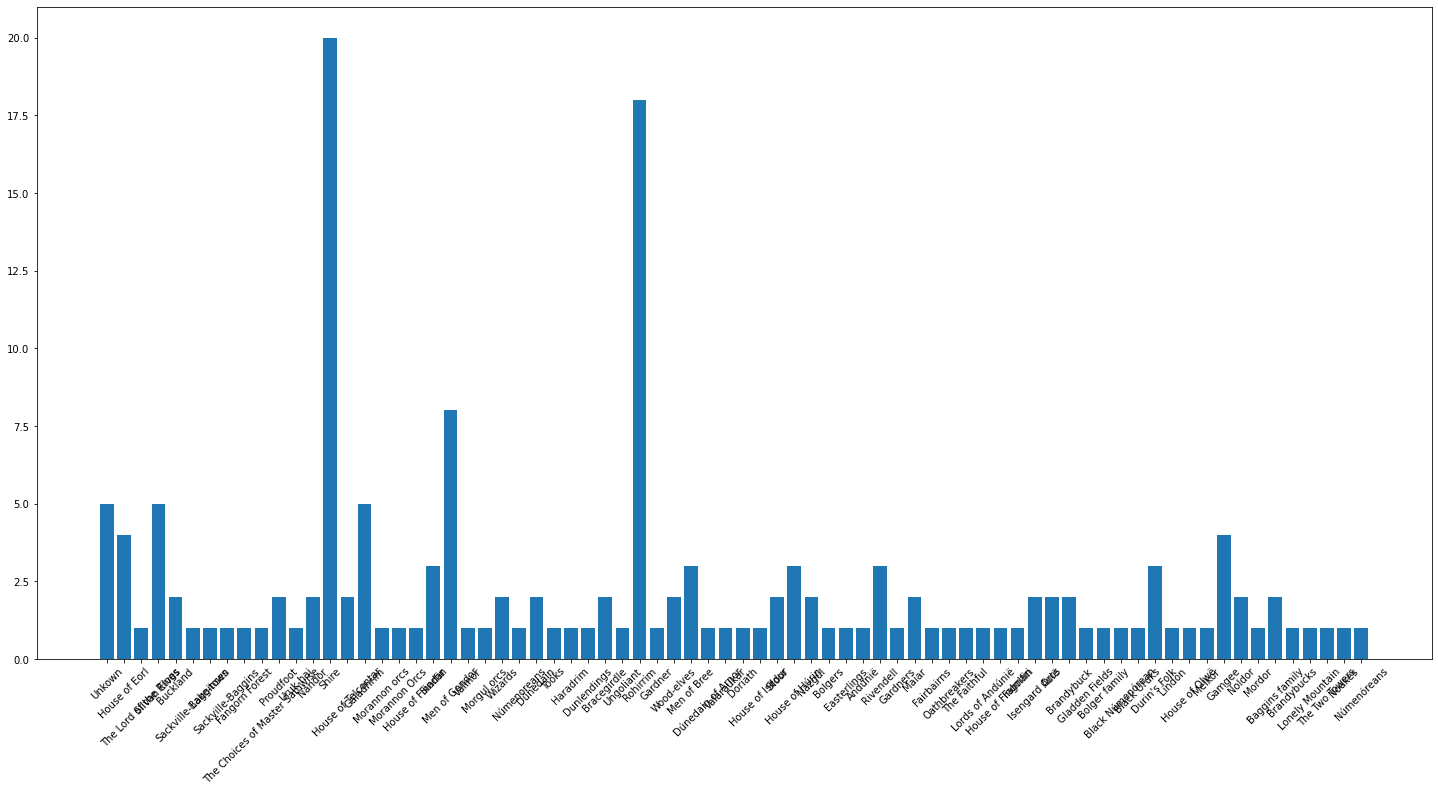

In [195]:
plt.figure(figsize=(25,12))
plt.bar(cultureCount.keys(),cultureCount.values())
plt.xticks(rotation=45)
plt.show()


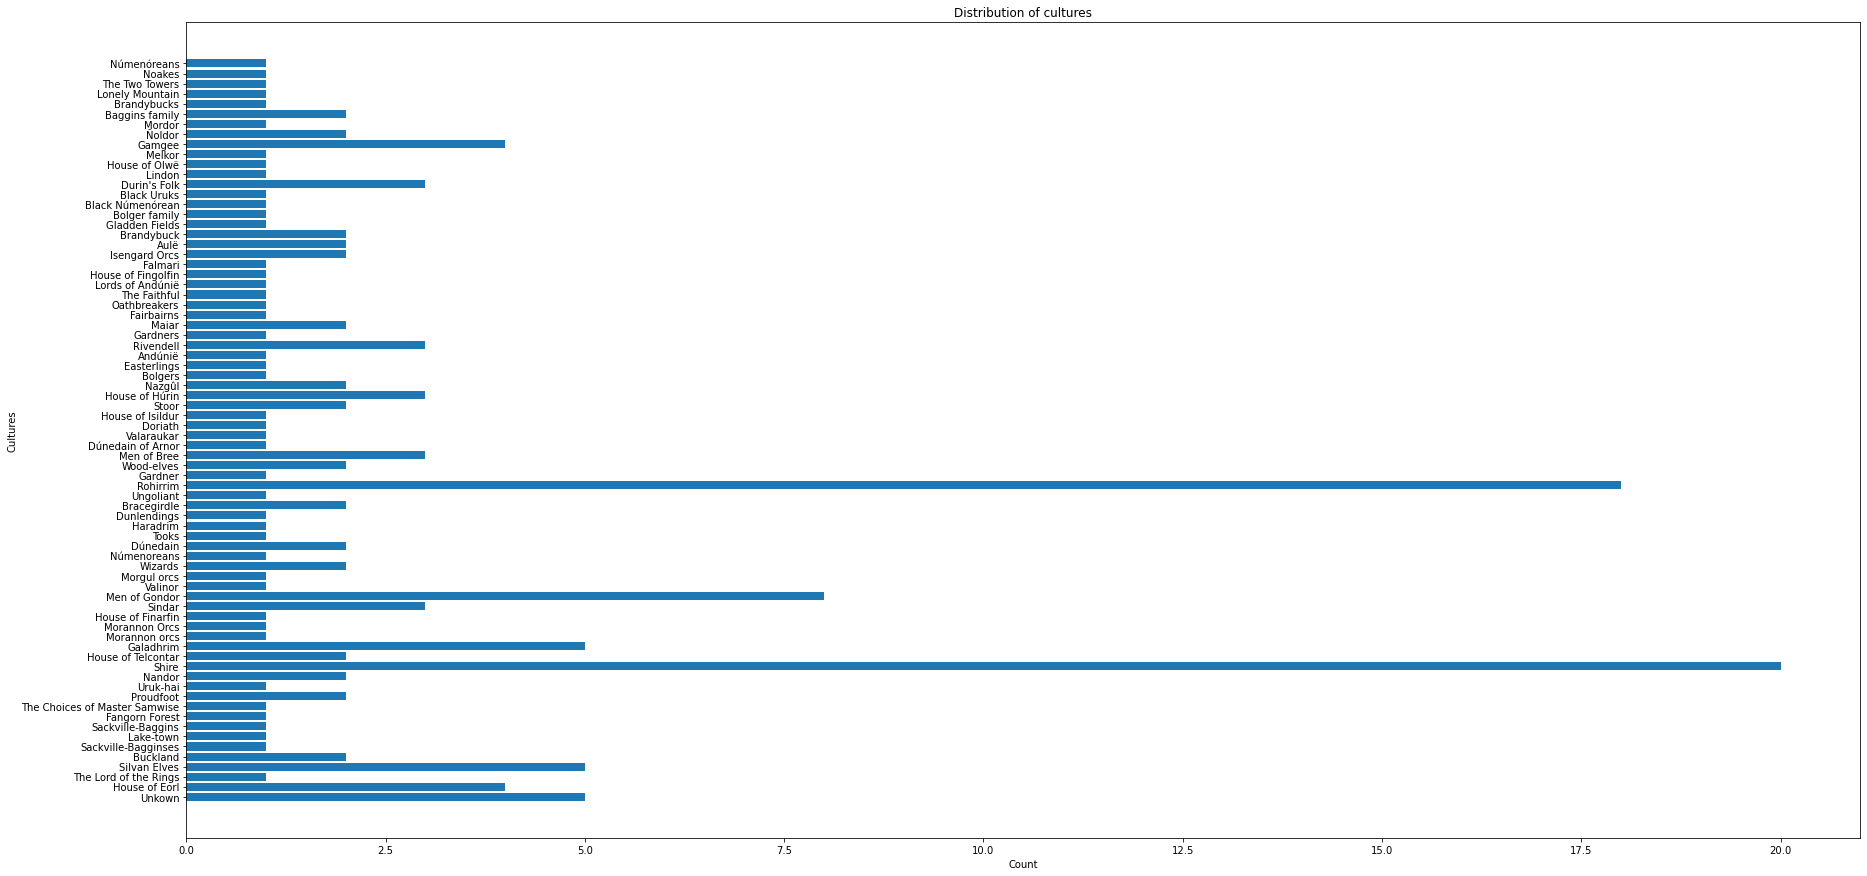

In [196]:
fig,ax = plt.subplots(figsize=(30,15))
ax.barh(list(cultureCount.keys()),cultureCount.values(),align = 'center')
ax.set_xlabel('Count')
ax.set_ylabel('Cultures')
ax.set_title('Distribution of cultures')
# ax.set_xscale('log')
plt.show()

In [197]:
#TODO filtera út spes dót (Elijah Wood,Two towers)

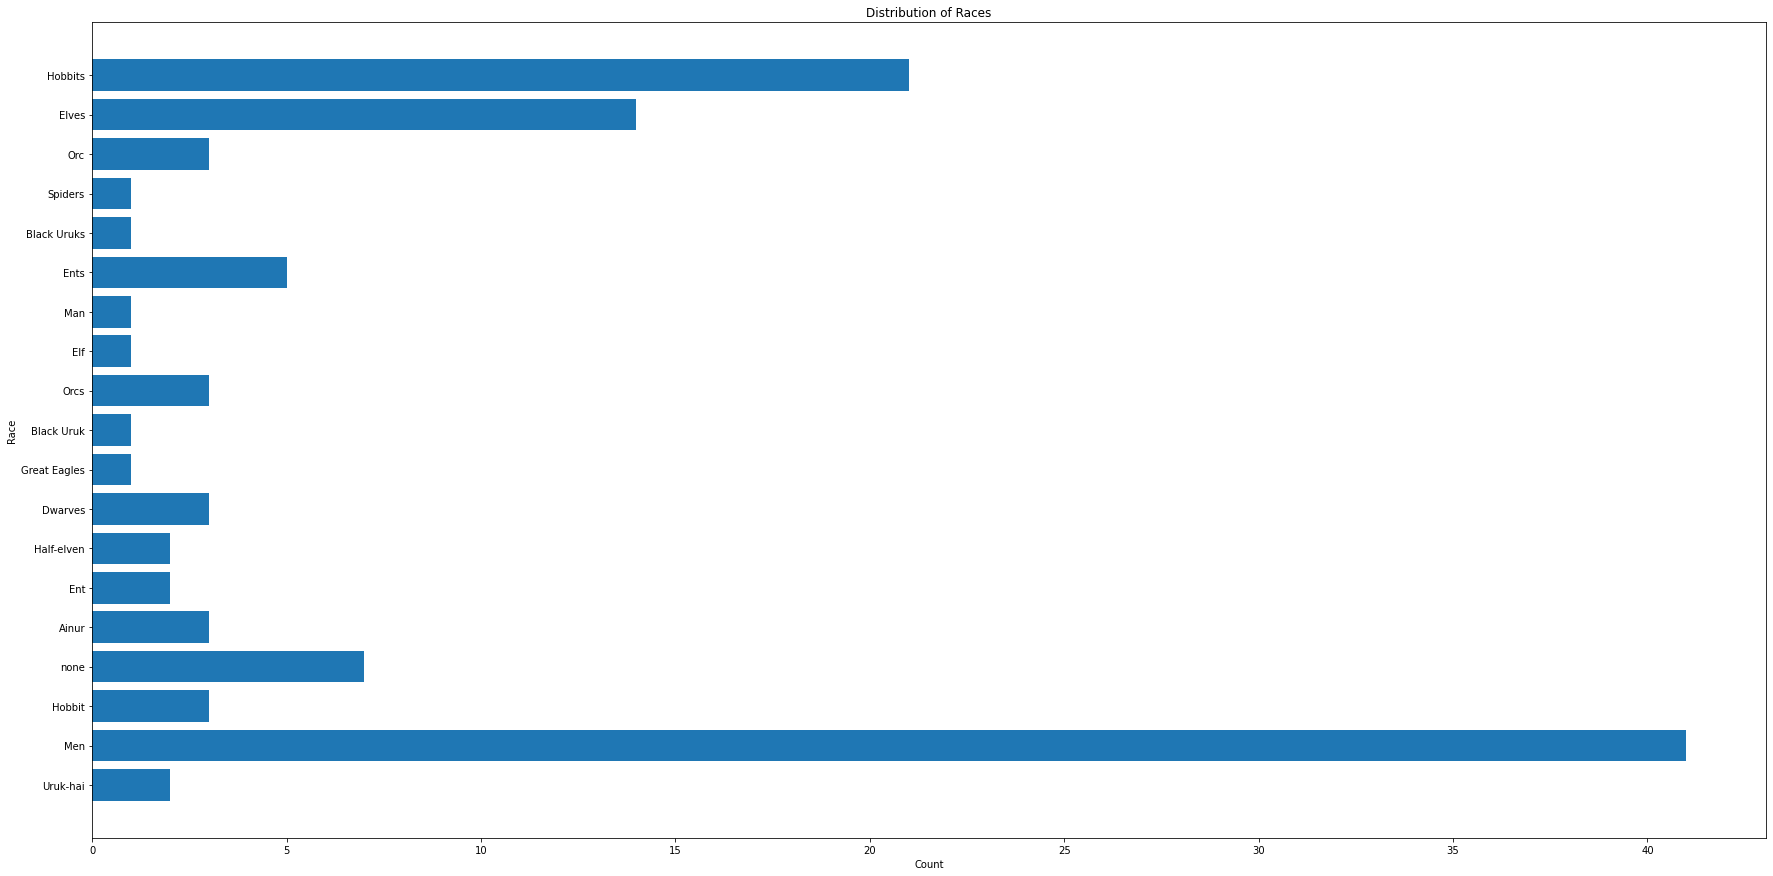

In [198]:
fig,ax = plt.subplots(figsize=(30,15))
ax.barh(list(raceCount.keys()),raceCount.values(),align = 'center')
ax.set_xlabel('Count')
ax.set_ylabel('Race')
ax.set_title('Distribution of Races')
# ax.set_xscale('log')
plt.show()

In [199]:
#TODO SAMEINA EIN OG FLEIRTÖLU (orc/orcs, man/men, hobbit/hobbits)

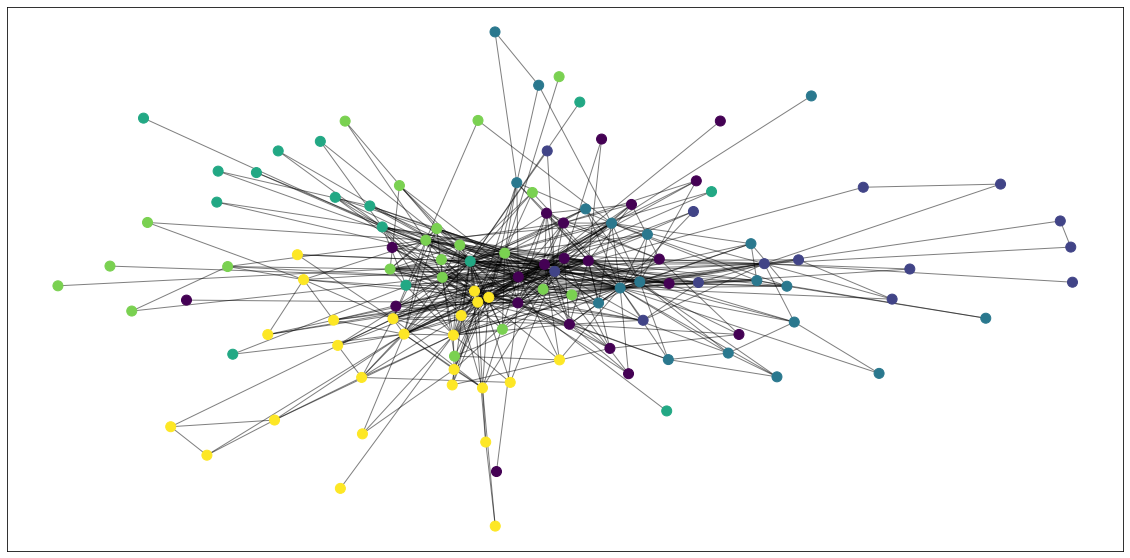

{'Aragorn II Elessar': 0, 'Isildur': 0, 'Arwen': 0, 'Eldarion': 0, 'Elendil': 0, 'Elrond': 0, 'Galadriel': 0, 'Gandalf': 1, 'Sauron': 0, 'Bilbo Baggins': 1, 'Gollum': 2, 'Barliman Butterbur': 1, 'Frodo Baggins': 2, 'Boromir': 4, 'Peregrin Took': 4, 'Meriadoc Brandybuck': 4, 'Samwise Gamgee': 2, 'Legolas': 5, 'Gimli': 5, 'Saruman': 3, 'Watcher in the Water': 4, "Durin's Bane": 3, 'Éomer': 5, 'Théoden': 5, 'Gríma Wormtongue': 5, 'Denethor II': 4, 'Faramir': 4, 'Éowyn': 5, 'Witch-king of Angmar': 5, 'Mouth of Sauron': 0, 'Bill Ferny': 3, 'Celeborn': 0, 'Círdan': 0, 'Lurtz': 4, 'Glóin': 1, 'Farmer Maggot': 4, 'Shelob': 2, 'Gwaihir': 2, 'Rosie Cotton': 2, 'Elanor Gardner': 2, 'Balin': 1, 'Bell Boffin': 1, 'Minto Boffin': 1, 'Filibert Bolger': 1, 'Fredegar Bolger': 2, 'Uglúk': 4, 'Melilot Brandybuck': 4, 'Grishnákh': 4, 'Treebeard': 3, 'Calaglin': 0, 'Gil-galad': 0, 'Erestor': 0, 'Frodo Gardner': 2, 'Hamfast Gamgee': 2, 'Albert Dreary': 2, 'Dínendal': 2, 'Figwit': 0, 'Harry Goatleaf': 3, 'Dé

In [200]:
G = gcc.to_undirected()

#computing the best partition
partition = community_louvain.best_partition(G)

all_partitions = list(partition.values())

plt.figure(figsize=(20,10))
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print(partition)

100%|██████████| 2000/2000 [00:01<00:00, 1014.68it/s]


BarnesHut Approximation  took  0.27  seconds
Repulsion forces  took  1.49  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


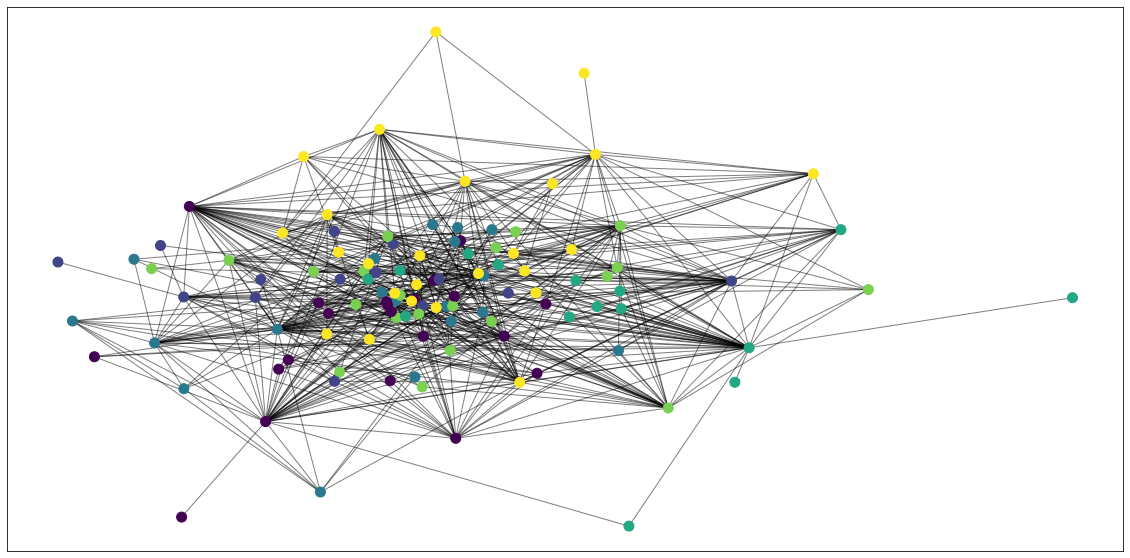

In [201]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(G, positions, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, positions, alpha=0.5)
plt.show()

In [202]:
#A list including all communities
allC = dict(Counter(all_partitions))
sorted_c = dict(sorted(allC.items()))

print("Number of communities: ", len(sorted_c.keys()))
print(allC)

Number of communities:  6
{0: 21, 1: 14, 2: 19, 4: 21, 5: 25, 3: 15}


In [203]:
community_list = []
for i in allC:
    tmp = []
    for key, value in partition.items():        
        if value == i:
            tmp.append(key)
    community_list.append((i,tmp))
print()

0 ['Aragorn II Elessar', 'Isildur', 'Arwen', 'Eldarion', 'Elendil', 'Elrond', 'Galadriel', 'Sauron', 'Mouth of Sauron', 'Celeborn', 'Círdan', 'Calaglin', 'Gil-galad', 'Erestor', 'Figwit', 'Déagol', 'Golradir', 'Linnar, Sindri, and Uri', 'Saelbeth', 'Silindë', 'King of the Dead']
1 ['Gandalf', 'Bilbo Baggins', 'Barliman Butterbur', 'Glóin', 'Balin', 'Bell Boffin', 'Minto Boffin', 'Filibert Bolger', 'Mrs. Bracegirdle', 'Otho Sackville-Baggins', 'Lobelia Sackville-Baggins', 'Mrs. Proudfoot', 'Odo Proudfoot', 'Guma']
2 ['Gollum', 'Frodo Baggins', 'Samwise Gamgee', 'Shelob', 'Gwaihir', 'Rosie Cotton', 'Elanor Gardner', 'Fredegar Bolger', 'Frodo Gardner', 'Hamfast Gamgee', 'Albert Dreary', 'Dínendal', 'Gorbag', 'Shagrat', 'Haldir of Lothlórien', 'Rúmil of Lórien', 'Orophin', 'Old Noakes', 'Ufthak']
4 ['Boromir', 'Peregrin Took', 'Meriadoc Brandybuck', 'Watcher in the Water', 'Denethor II', 'Faramir', 'Lurtz', 'Farmer Maggot', 'Uglúk', 'Melilot Brandybuck', 'Grishnákh', 'Hugin', 'Ted Sandyman

## We edited The txt file for frodo baggins, only the format of the file was changed but no content.

This was done so "Elijah Wood" would not be added as a culture.

Shelob text file, removed \<ref\>\<ref\>

In [217]:
# print(G.degree('Saruman'))
sortedDegree = [(node,G.degree(node)) for node in G.nodes()]
sortedDegree.sort(key=lambda y: y[1],reverse=True)
print(sortedDegree)

[('Saruman', 48), ('Frodo Baggins', 45), ('Sauron', 43), ('Aragorn II Elessar', 41), ('Gandalf', 36), ('Peregrin Took', 33), ('Meriadoc Brandybuck', 32), ('Gimli', 30), ('Galadriel', 28), ('Legolas', 28), ('Éomer', 27), ('Elrond', 26), ('Théoden', 25), ('Samwise Gamgee', 24), ('Gollum', 22), ('Bilbo Baggins', 20), ('Faramir', 20), ('Boromir', 19), ('Éowyn', 19), ('Witch-king of Angmar', 19), ('Arwen', 18), ('Treebeard', 18), ('Celeborn', 17), ('Gríma Wormtongue', 14), ('Isildur', 11), ('Denethor II', 11), ('Uglúk', 10), ('Háma', 10), ('Watcher in the Water', 9), ('Mouth of Sauron', 9), ('Círdan', 9), ('Shelob', 9), ('Gwaihir', 9), ('Grishnákh', 9), ('Haldir of Lothlórien', 9), ('Gothmog (Lieutenant of Morgul)', 9), ('Gamling', 9), ('Elendil', 8), ('Glóin', 8), ('Shagrat', 8), ('Théodred', 8), ('Eldarion', 7), ("Durin's Bane", 7), ('Gil-galad', 7), ('Snaga (Isengard)', 7), ('Murgash', 7), ('Rosie Cotton', 6), ('Elanor Gardner', 6), ('Balin', 6), ('Hamfast Gamgee', 6), ('Figwit', 6), ('G